Ratings Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
Movies Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


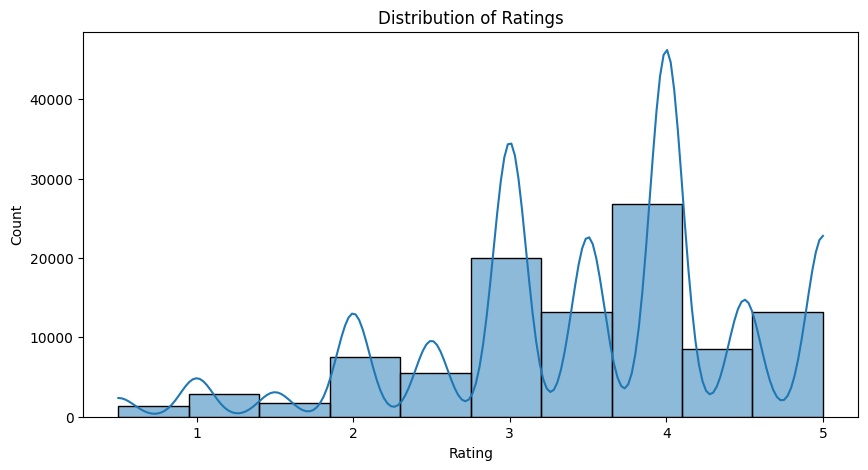

<ipython-input-5-f21de26b3f84>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_movies['title'], x=top_movies['rating'], palette='coolwarm')


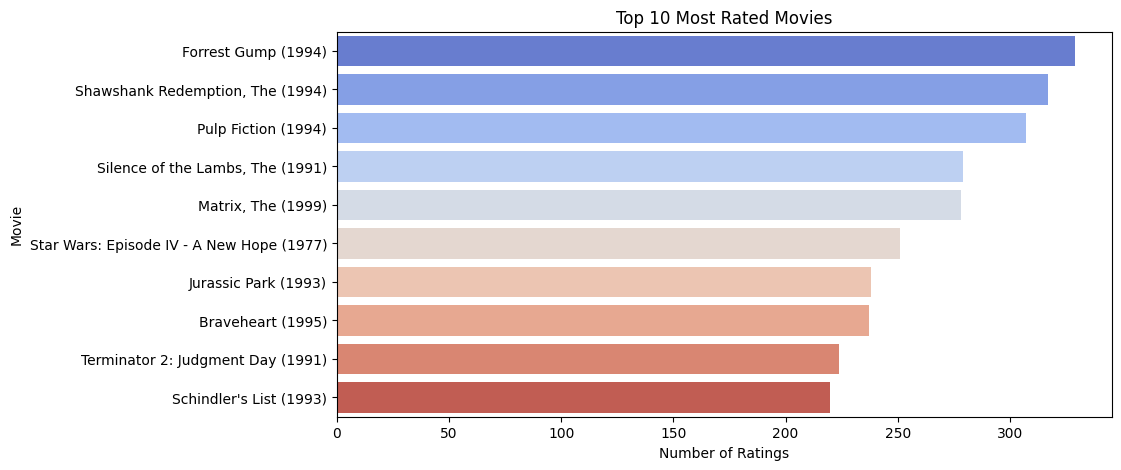

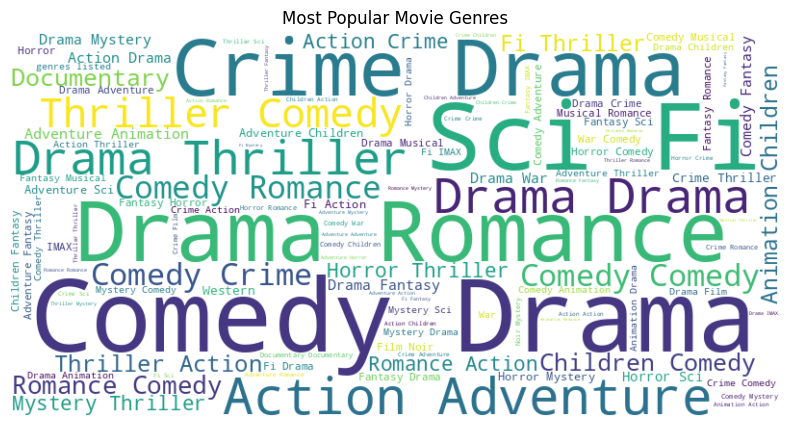

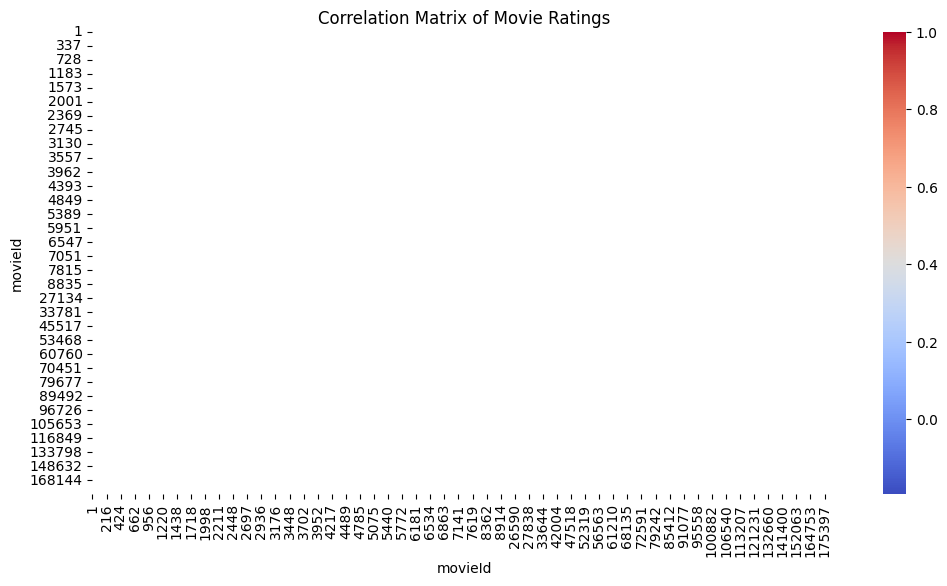

Top Recommended Movies:
      movieId                                              title
224       260          Star Wars: Episode IV - A New Hope (1977)
507       589                  Terminator 2: Judgment Day (1991)
898      1196  Star Wars: Episode V - The Empire Strikes Back...
899      1197                         Princess Bride, The (1987)
900      1198  Raiders of the Lost Ark (Indiana Jones and the...
902      1200                                      Aliens (1986)
911      1210  Star Wars: Episode VI - Return of the Jedi (1983)
939      1240                             Terminator, The (1984)
1503     2028                         Saving Private Ryan (1998)
1939     2571                                 Matrix, The (1999)


In [5]:
# Personalized Movie Recommendation System
# A Complete Data Analytics-Oriented Approach

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile
import io
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import os

# Download and load the IMDB dataset
def load_imdb_data():
    url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content), "r") as zip_ref:
        zip_ref.extractall("ml-latest-small")

    ratings = pd.read_csv("/content/ml-latest-small/ml-latest-small/ratings.csv")
    movies = pd.read_csv("/content/ml-latest-small/ml-latest-small/movies.csv")
    return ratings, movies

# Exploratory Data Analysis (EDA)
def perform_eda(ratings, movies):
    print("Ratings Dataset Info:")
    print(ratings.info())
    print("Movies Dataset Info:")
    print(movies.info())

    # Ratings distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(ratings['rating'], bins=10, kde=True)
    plt.title("Distribution of Ratings")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.show()

    # Most rated movies
    top_movies = ratings.groupby('movieId').count()['rating'].sort_values(ascending=False).head(10)
    top_movies = top_movies.reset_index().merge(movies, on='movieId')
    plt.figure(figsize=(10, 5))
    sns.barplot(y=top_movies['title'], x=top_movies['rating'], palette='coolwarm')
    plt.title("Top 10 Most Rated Movies")
    plt.xlabel("Number of Ratings")
    plt.ylabel("Movie")
    plt.show()

    # Word Cloud for most popular movie genres
    all_genres = ' '.join(movies['genres'].dropna().str.replace('|', ' '))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Most Popular Movie Genres")
    plt.show()

    # Correlation matrix between user interactions and ratings
    user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    correlation_matrix = user_movie_matrix.corr()
    plt.figure(figsize=(12, 6))
    sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Matrix of Movie Ratings")
    plt.show()

# Create a user-item matrix for collaborative filtering
def create_user_item_matrix(ratings):
    user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    return user_item_matrix

# Build a collaborative filtering model using SVD
def build_svd_model(user_item_matrix, num_components=20):
    matrix = csr_matrix(user_item_matrix)
    svd = TruncatedSVD(n_components=num_components)
    reduced_matrix = svd.fit_transform(matrix)
    return reduced_matrix, svd

# Find similar movies based on cosine similarity
def find_similar_movies(movie_id, user_item_matrix, svd):
    matrix = csr_matrix(user_item_matrix)
    transformed_matrix = svd.transform(matrix)
    similarity = cosine_similarity(transformed_matrix)
    movie_index = list(user_item_matrix.columns).index(movie_id)
    similar_movies = np.argsort(-similarity[movie_index])[1:11]
    return [list(user_item_matrix.columns)[i] for i in similar_movies]

# Generate recommendations for a user
def recommend_movies(user_id, user_item_matrix, svd, movies):
    user_index = user_id - 1
    predicted_ratings = svd.inverse_transform(svd.transform(user_item_matrix))
    top_movie_indices = np.argsort(-predicted_ratings[user_index])[:10]
    top_movies = [user_item_matrix.columns[i] for i in top_movie_indices]
    return movies[movies['movieId'].isin(top_movies)]

# Main Execution
if __name__ == "__main__":
    ratings, movies = load_imdb_data()
    perform_eda(ratings, movies)

    user_item_matrix = create_user_item_matrix(ratings)
    reduced_matrix, svd = build_svd_model(user_item_matrix)

    test_user = 1
    recommendations = recommend_movies(test_user, user_item_matrix, svd, movies)
    print("Top Recommended Movies:")
    print(recommendations[['movieId', 'title']])